In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import time

In [2]:
class GridWorld:
    def __init__(self, size=100, obstacle_density=0.3, min_distance_factor=0.7):
        self.size = size
        self.grid = np.zeros((size, size))
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up
        self.action_names = ['right', 'down', 'left', 'up']
        
        min_distance = int(size * min_distance_factor)
        
        regions = [
            (0, 0, size//3, size//3),                    # top-left region
            (size*2//3, size*2//3, size-1, size-1)      # bottom-right region
        ]
        
        # Randomly select start from first region and goal from second region
        start_region, goal_region = regions
        self.start = (random.randint(start_region[0], start_region[2]), 
                     random.randint(start_region[1], start_region[3]))
        self.goal = (random.randint(goal_region[0], goal_region[2]), 
                    random.randint(goal_region[1], goal_region[3]))
        
        while self._calculate_manhattan_distance(self.start, self.goal) < min_distance:
            self.goal = (random.randint(goal_region[0], goal_region[2]), 
                        random.randint(goal_region[1], goal_region[3]))
        
        self._generate_obstacles(obstacle_density)
        
        self.grid[self.start] = 2
        self.grid[self.goal] = 3
        
        print(f"Start position: {self.start}")
        print(f"Goal position: {self.goal}")
        print(f"Manhattan distance: {self._calculate_manhattan_distance(self.start, self.goal)}")

    def _calculate_manhattan_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def _generate_obstacles(self, density):
        path_width = 3
        x1, y1 = self.start
        x2, y2 = self.goal
        
        num_obstacles = int(self.size * self.size * density)
        obstacles_placed = 0
        
        while obstacles_placed < num_obstacles:
            x, y = random.randint(0, self.size-1), random.randint(0, self.size-1)
            
            # Check if position is in the path corridor
            in_vertical_corridor = (min(x1, x2) - path_width <= x <= max(x1, x2) + path_width and 
                                  abs(y - y1) <= path_width)
            in_horizontal_corridor = (min(y1, y2) - path_width <= y <= max(y1, y2) + path_width and 
                                    abs(x - x2) <= path_width)
            
            if ((x, y) != self.start and (x, y) != self.goal and 
                not in_vertical_corridor and not in_horizontal_corridor and 
                self.grid[x, y] == 0):
                self.grid[x, y] = 1
                obstacles_placed += 1

    def is_valid_state(self, state):
        x, y = state
        return (0 <= x < self.size and 
                0 <= y < self.size and 
                self.grid[x, y] != 1)

    def get_next_state(self, state, action):
        next_x = state[0] + self.actions[action][0]
        next_y = state[1] + self.actions[action][1]
        
        if self.is_valid_state((next_x, next_y)):
            return (next_x, next_y)
        return state

    def get_reward(self, state):
        if state == self.goal:
            return 100
        return -1

    def is_terminal(self, state):
        return state == self.goal

In [3]:
class ValueIteration:
    def __init__(self, env, gamma=0.99, theta=1e-6):
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.V = defaultdict(float)
        self.policy = {}
        self.convergence_steps = 0

    def solve(self, max_iterations=1000):
        for iteration in range(max_iterations):
            delta = 0
            for x in range(self.env.size):
                for y in range(self.env.size):
                    if self.env.grid[x, y] == 1:
                        continue
                    
                    state = (x, y)
                    if self.env.is_terminal(state):
                        continue
                        
                    v = self.V[state]
                    max_v = float('-inf')
                    best_action = None
                    
                    for action in range(len(self.env.actions)):
                        next_state = self.env.get_next_state(state, action)
                        reward = self.env.get_reward(next_state)
                        v_next = reward + self.gamma * self.V[next_state]
                        
                        if v_next > max_v:
                            max_v = v_next
                            best_action = action
                    
                    self.V[state] = max_v
                    self.policy[state] = best_action
                    delta = max(delta, abs(v - self.V[state]))
            
            self.convergence_steps = iteration + 1
            if delta < self.theta:
                break
        
        return self.V, self.policy, self.convergence_steps

In [4]:
class QLearning:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: defaultdict(float))
        self.policy = {}
        self.convergence_steps = 0

    def get_action(self, state):
        if random.random() < self.epsilon:
            # Exploration: choose random action
            return random.randrange(len(self.env.actions))
        else:
            # Exploitation: choose best action based on Q-values
            q_values = {a: self.Q[state][a] for a in range(len(self.env.actions))}
            # If all values are 0, choose random action
            if all(v == 0 for v in q_values.values()):
                return random.randrange(len(self.env.actions))
            # Otherwise choose the action with maximum Q-value
            return max(q_values.items(), key=lambda x: x[1])[0]

    def solve(self, episodes=10000):
        prev_policy = None
        stable_episodes = 0
        required_stable_episodes = 50  # Number of episodes policy should remain stable
        
        for episode in range(episodes):
            state = self.env.start
            
            while not self.env.is_terminal(state):
                action = self.get_action(state)
                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(next_state)
                
                # Get best next action based on Q-values
                best_next_q = max([self.Q[next_state][a] for a in range(len(self.env.actions))])
                
                # Q-learning update
                td_target = reward + self.gamma * best_next_q
                td_error = td_target - self.Q[state][action]
                self.Q[state][action] += self.alpha * td_error
                
                state = next_state
            
            current_policy = {}
            for x in range(self.env.size):
                for y in range(self.env.size):
                    state = (x, y)
                    if not self.env.is_terminal(state) and self.env.grid[state] != 1:
                        q_values = {a: self.Q[state][a] for a in range(len(self.env.actions))}
                        current_policy[state] = max(q_values.items(), key=lambda x: x[1])[0]
            
            if prev_policy is not None and current_policy == prev_policy:
                stable_episodes += 1
                if stable_episodes >= required_stable_episodes:
                    self.convergence_steps = episode + 1
                    break
            else:
                stable_episodes = 0
            
            prev_policy = current_policy.copy()
            self.policy = current_policy
            
            if episode == episodes - 1:
                self.convergence_steps = episodes
        
        return self.Q, self.policy, self.convergence_steps

In [5]:
def visualize_policy(env, policy, title="Policy Visualization"):
    plt.figure(figsize=(10, 10))
    
    cmap = plt.cm.colors.ListedColormap(['white', 'black', 'green', 'yellow'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(env.grid, cmap=cmap, norm=norm)
    
    for state, action in policy.items():
        if not env.is_terminal(state) and env.grid[state] != 1:
            dx, dy = env.actions[action]
            plt.arrow(state[1], state[0], 
                     dy*0.3, dx*0.3,
                     head_width=0.3, head_length=0.3, 
                     fc='red', ec='red')
    
    plt.title(title)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='Empty'),
        Patch(facecolor='black', edgecolor='black', label='Obstacle'),
        Patch(facecolor='green', edgecolor='black', label='Start'),
        Patch(facecolor='yellow', edgecolor='black', label='Goal'),
        Patch(facecolor='red', edgecolor='red', label='Policy Direction')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

In [6]:
def benchmark_algorithms(env):
    results = {}
    
    # MDP
    start_time = time.time()
    vi = ValueIteration(env)
    vi_values, vi_policy, vi_steps = vi.solve()
    vi_time = time.time() - start_time
    vi_path = trace_optimal_path(env, vi_policy)
    results['Value Iteration'] = {
        'time': vi_time, 
        'policy': vi_policy, 
        'path': vi_path,
        'convergence_steps': vi_steps
    }
    
    # Q-Learning
    start_time = time.time()
    ql = QLearning(env)
    ql_values, ql_policy, ql_steps = ql.solve()
    ql_time = time.time() - start_time
    ql_path = trace_optimal_path(env, ql_policy)
    results['Q-Learning'] = {
        'time': ql_time, 
        'policy': ql_policy, 
        'path': ql_path,
        'convergence_steps': ql_steps
    }
    
    return results

In [7]:
def trace_optimal_path(env, policy):
    path = [env.start]
    current_state = env.start
    steps = 0
    max_steps = env.size * env.size 
    
    while current_state != env.goal and steps < max_steps:
        if current_state not in policy:
            return None 
        action = policy[current_state]
        current_state = env.get_next_state(current_state, action)
        path.append(current_state)
        steps += 1
    
    return path if current_state == env.goal else None

def visualize_policy_with_path(env, policy, path, title="Policy Visualization", convergence_steps=None):
    plt.figure(figsize=(12, 10))
    
    cmap = plt.cm.colors.ListedColormap(['white', 'black', 'green', 'yellow'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(env.grid, cmap=cmap, norm=norm)
    
    for state, action in policy.items():
        if not env.is_terminal(state) and env.grid[state] != 1:
            dx, dy = env.actions[action]
            plt.arrow(state[1], state[0], 
                     dy*0.3, dx*0.3,
                     head_width=0.3, head_length=0.3, 
                     fc='red', ec='red', alpha=0.5)
    
    if path:
        path_x = [state[0] for state in path]
        path_y = [state[1] for state in path]
        plt.plot(path_y, path_x, 'b-', linewidth=3, label=f'Optimal Path (Length: {len(path)-1})')
    
    metrics_str = f"\nOptimal Path Length: {len(path)-1} steps"
    if convergence_steps is not None:
        metrics_str += f"\nConvergence Steps: {convergence_steps}"
    plt.title(title + metrics_str)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='Empty'),
        Patch(facecolor='black', edgecolor='black', label='Obstacle'),
        Patch(facecolor='green', edgecolor='black', label='Start'),
        Patch(facecolor='yellow', edgecolor='black', label='Goal'),
        Patch(facecolor='red', edgecolor='red', label='Policy Direction'),
        Patch(facecolor='blue', edgecolor='blue', label='Optimal Path')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

Start position: (12, 28)
Goal position: (85, 83)
Manhattan distance: 128

Detailed Results:

Value Iteration:
Time taken: 23.83 seconds
Convergence steps: 1000
Optimal path length: 128 steps

Q-Learning:
Time taken: 103.86 seconds
Convergence steps: 4403
Optimal path length: 130 steps


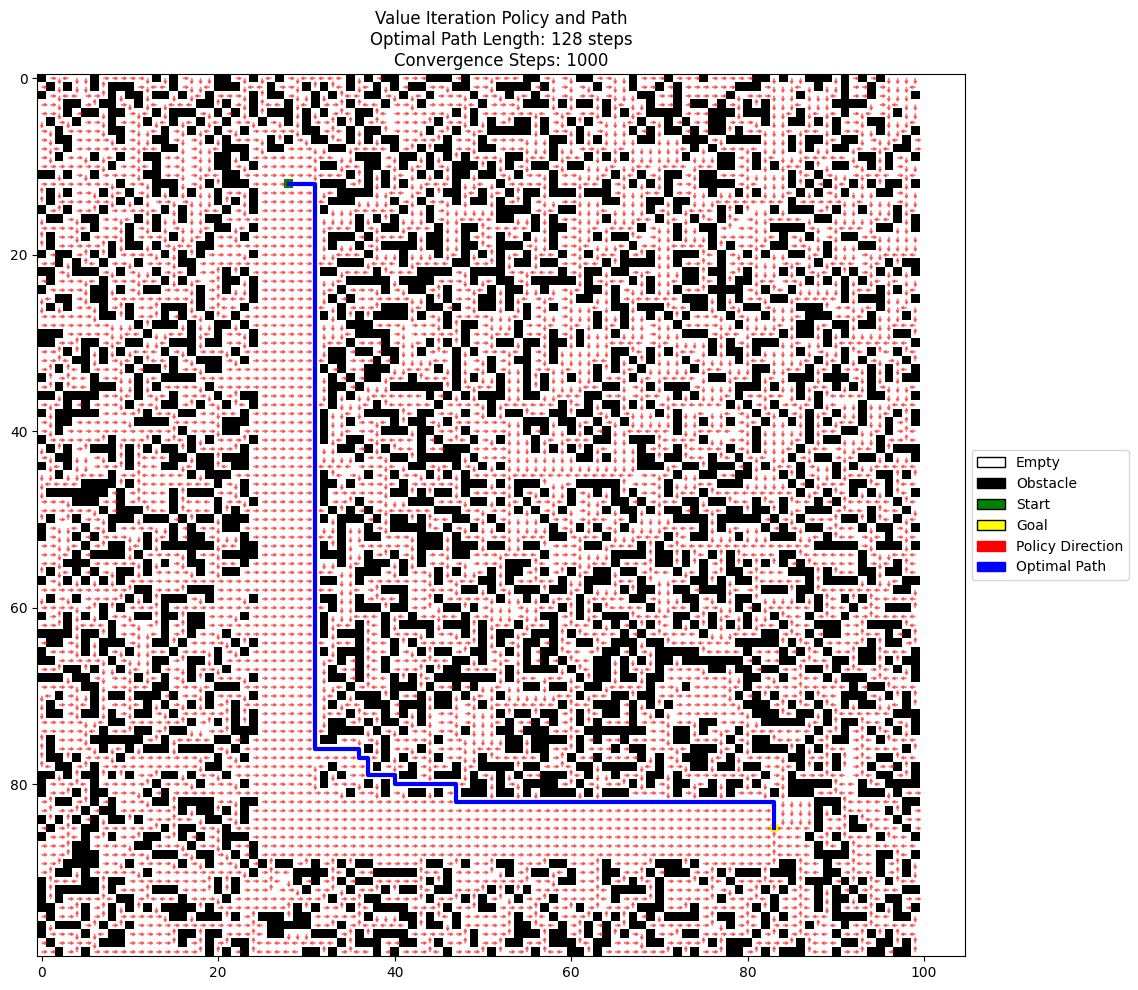

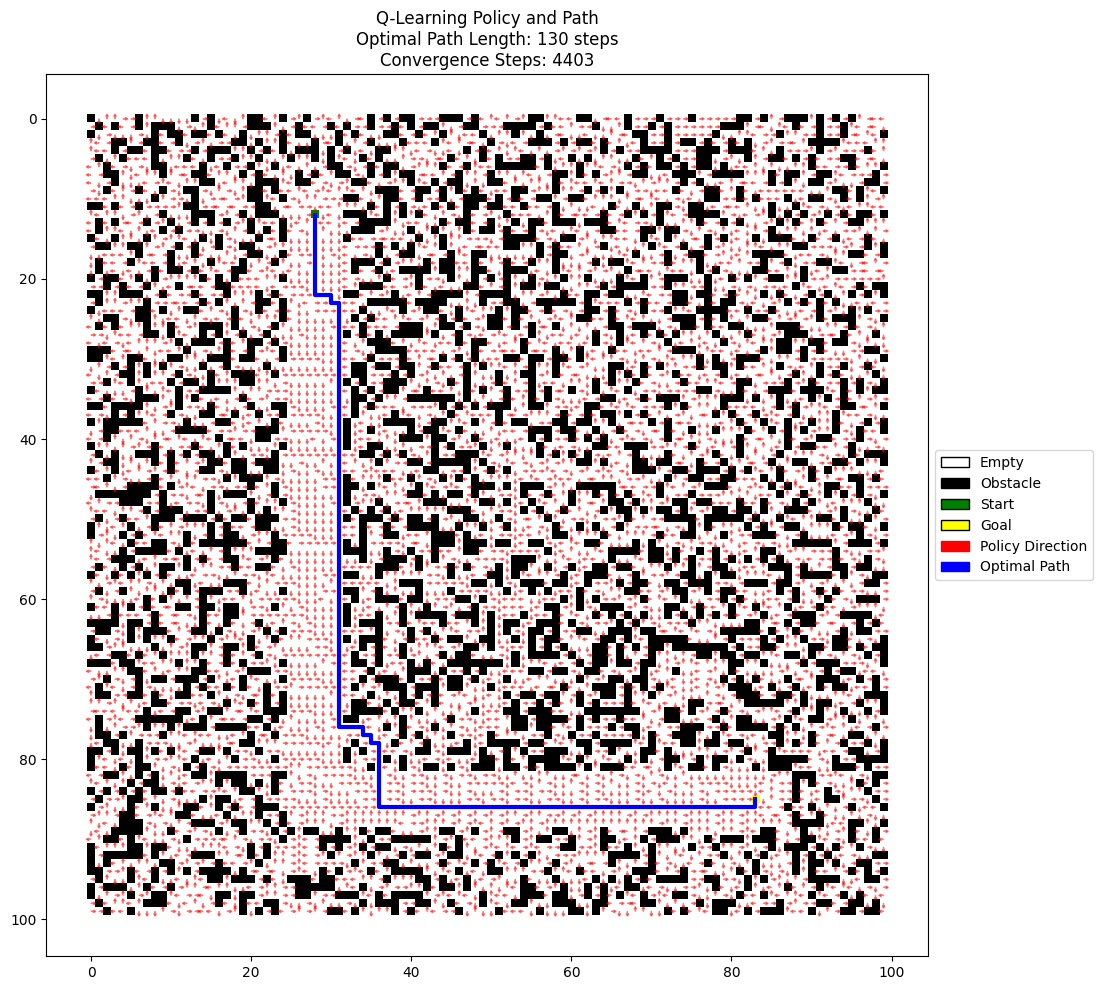

In [8]:
env = GridWorld(size=100, obstacle_density=0.3)
results = benchmark_algorithms(env)

print("\nDetailed Results:")
for algorithm, data in results.items():
    print(f"\n{algorithm}:")
    print(f"Time taken: {data['time']:.2f} seconds")
    print(f"Convergence steps: {data['convergence_steps']}")
    if data['path']:
        print(f"Optimal path length: {len(data['path'])-1} steps")
    else:
        print("No valid path found")

for algorithm, data in results.items():
    visualize_policy_with_path(
        env, 
        data['policy'], 
        data['path'],
        f"{algorithm} Policy and Path",
        data['convergence_steps']
    )